<h1>Hierarchical models</h1>

<p>Suppose we want to anlyze the quality of water in a city, so we take samples by divigng the city into neighborhoods. We may think we have two options to analyze this data:</p>

<ul>
    <li>Estimate variables for each neighborhoods as separete entities</li>
    <li>Pool the data together and estimate water quality of the city as a single big group</li>
</ul>

<p>Depends on what we would like to do booth could be reasonable options. However, we can do something between booth, actually we can do booth by construct a model that estiamtes the water quality of each neighborhood and estimates the water quality of the whole city. This type of model is know as hierarchical model or multilevel model.</p>

<p>Construct a hierachical model is just a fancy way of saying that we are putting shared priors over our priors.These priors are called hyper-priors, and their parameters hyper-parameters.</p>

In [1]:
import pandas as pd
import arviz as az
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
%matplotlib inline

<p>To ilustrate hierarquiqual model we are gonna to use data about heart attack of patients treated at varioues hospitals in New York City.</p>

In [2]:
data = pd.read_csv("../data/DeathHeartAttackManhattan.csv")
data.head()

,Hospital,Cases,Deaths,Death %
0,Bellevue Hospital Center,129,4,3.101
1,Harlem Hospital Center,35,1,2.857
2,Lenox Hill Hospital,228,18,7.894
3,Metropolitan Hospital Center,84,7,8.333
4,Mount Sinai Beth Israel,291,24,8.247


/usr/local/lib/python3.10/dist-packages/pymc/data.py:427: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


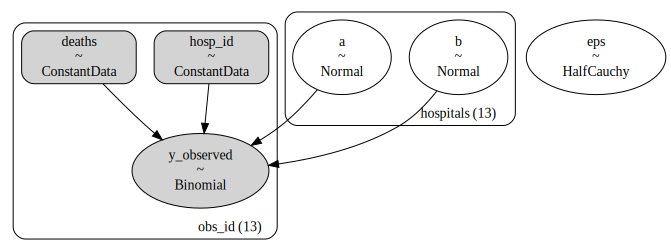

In [3]:
hosp_idxs, hospitals = pd.factorize(data.Hospital)
coords = {
    "hospitals": hospitals,
    "obs_id": np.arange(len(hosp_idxs)),
}
deaths = data['Deaths'].values
n = data['Cases'].values

with pm.Model(coords=coords) as random_model:

    # Independent parameters for each county
    hosp_idx = pm.Data("hosp_id", hosp_idxs, dims="obs_id")
    death = pm.Data("deaths", deaths, dims="obs_id")

    a = pm.Normal("a", 0, sigma=100, dims="hospitals")
    b = pm.Normal("b", 0, sigma=100, dims="hospitals")

    # Model error
    eps = pm.HalfCauchy("eps", 5)

  
    radon_est = pm.invlogit(a[hosp_idx] + b[hosp_idx] * death)

    
    y_observed = pm.Binomial("y_observed", n = n, p = radon_est, observed = deaths, dims="obs_id")
    
pm.model_to_graphviz(random_model)

In [4]:
with random_model:
    
    #using MCMC trough NUTS
    samples  = pm.sample(3000, tune = 1000, cores = 4, random_seed = 42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 401 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


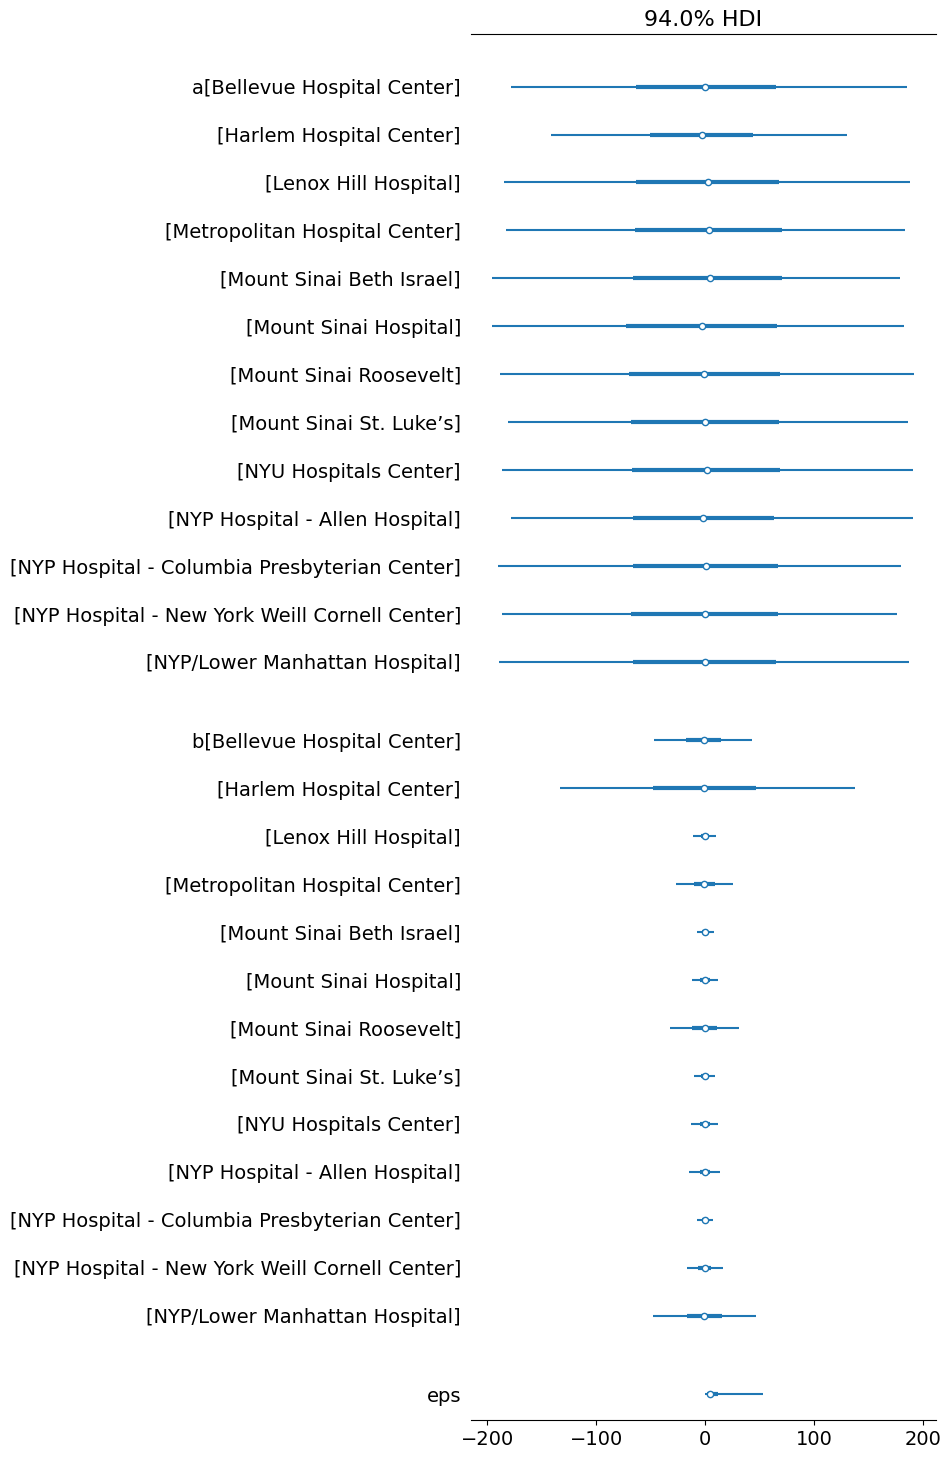

In [5]:
az.plot_forest(
    samples, 
    # ess=True, r_hat=True, 
    combined=True,
    figsize=(6,18)
);